<a href="https://colab.research.google.com/github/ElisabethKugler/TensorFlowCourse/blob/master/EK_Tensorflow_Flower_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning: from the Udacity Course "Introduction to Tensorflow" 
use Google Colab "https://colab.research.google.com/?utm_source=scs-index"

In [ ]:
### Imports
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub # for trained models
import tensorflow_datasets as tfds # use datasets

from tensorflow.keras import layers # keras API for layers

In [ ]:
### Error Logging
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
### Load Data from TensorFlow Datasets
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'], # 70% train, 30% validate
    with_info=True, # include info
    as_supervised=True, # the resulting Dataset will be a collection of tuples containing a label for each input
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
### Print Dataset Information
num_classes = dataset_info.features['label'].num_classes

# count nr of images
num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

# print 
print('Total number of classes is:', num_classes)
print('Number of training images is:',num_training_examples)
print('Number of validation images is:',num_validation_examples)

Total number of classes is: 5
Number of training images is: 2569
Number of validation images is: 1101


In [ ]:
### Reformat Images and Create Batches
# resize
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

# create batches
BATCH_SIZE = 32

# .shuffle - so you mix the order and algorithm learns data and not their ordder
# .map - to apply image reformatting
# .batch - use batch of 32
# .prefetch - so the next image is loaded (RAM efficient)
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

# no need to shuffle here as they haven't been seen before
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [ ]:
### TRANSFER LEARNING
### Create Model

# feature extractor (feature = partial model from TensorFlow Hub (without the final classification layer))
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

# freeze the pre-trained model (you only want to train the final classification layer)
feature_extractor.trainable = False

# attach your own classification head
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes)
])

# get model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
### Train the Model
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 66s 809ms/step - loss: 0.3838 - accuracy: 0.8692 - val_loss: 0.3472 - val_accuracy: 0.8801
Epoch 2/6
81/81 [==============================] - 65s 803ms/step - loss: 0.2863 - accuracy: 0.9023 - val_loss: 0.3323 - val_accuracy: 0.8937
Epoch 3/6
81/81 [==============================] - 65s 802ms/step - loss: 0.2356 - accuracy: 0.9268 - val_loss: 0.3006 - val_accuracy: 0.9010
Epoch 4/6
81/81 [==============================] - 66s 815ms/step - loss: 0.1975 - accuracy: 0.9416 - val_loss: 0.2947 - val_accuracy: 0.9028
Epoch 5/6
81/81 [==============================] - 65s 803ms/step - loss: 0.1719 - accuracy: 0.9541 - val_loss: 0.2812 - val_accuracy: 0.9119
Epoch 6/6
81/81 [==============================] - 62s 769ms/step - loss: 0.1541 - accuracy: 0.9622 - val_loss: 0.2807 - val_accuracy: 0.9064


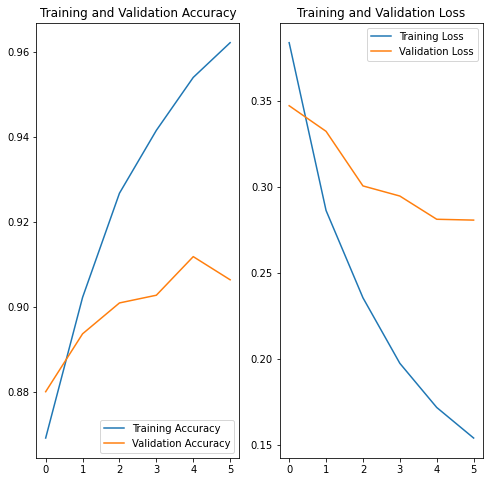

In [11]:
### Plot Training and Validation Graphs
# get metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

### make figure and plot
epochs_range = range(EPOCHS)
# accuracy plot
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

['daisy' 'tulips' 'dandelion' 'dandelion' 'roses' 'roses' 'roses'
 'dandelion' 'daisy' 'dandelion' 'tulips' 'daisy' 'tulips' 'dandelion'
 'sunflowers' 'sunflowers' 'sunflowers' 'dandelion' 'dandelion'
 'dandelion' 'roses' 'sunflowers' 'roses' 'daisy' 'tulips' 'dandelion'
 'dandelion' 'tulips' 'roses' 'roses' 'dandelion' 'roses']
Labels:            [1 2 0 0 4 4 4 0 1 0 2 1 2 0 3 3 3 0 0 0 4 3 4 1 2 0 0 2 4 4 0 4]
Predicted labels:  [1 2 0 0 4 4 4 0 1 0 2 1 2 0 3 3 3 0 0 0 4 3 4 1 2 0 0 2 4 4 0 4]


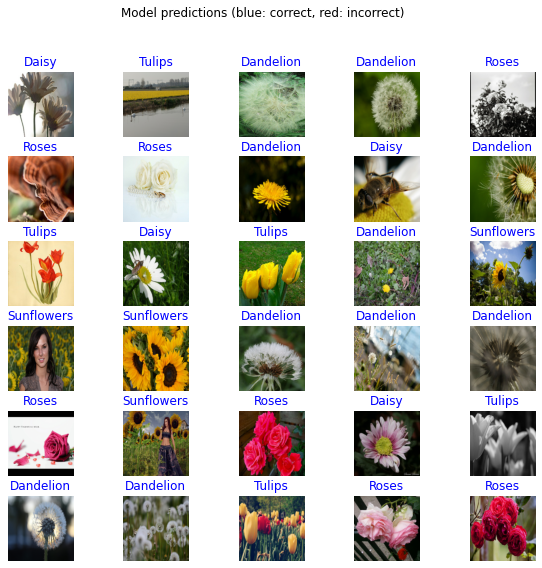

In [17]:
### CHECK PREDICTIONS
# check label names
class_names = np.array(dataset_info.features['label'].names)
# print(class_names)

# Create a batch and its corresponding label
image_batch, label_batch = next(iter(train_batches))
# convert the image and label batch into numpy array
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

# Make Predictions
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy() # squeeze to remove dimensionality

# get the indices of the best prediction for each image
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)


# Print True Labels and Predicted Indices
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

# Plot Model Predictions

plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red" # blue = correct; red = false
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")